In [7]:
import os
from collections import defaultdict
import pandas as pd
import numpy as np

# ── CONFIG ──────────────────────────────────────────────────────────────────────
DATA_DIR              = r'./data/'   # ← change this
N_COMPANIES           = 158                                    # 1.csv … 158.csv
OUTPUT_FILE           = os.path.join(DATA_DIR, 'all_usage_halfhour.csv')
GAP_WARN_HRS          = 4   # print a heads-up for any gap > 4 h
GAP_NAN_THRESHOLD_HRS = 6   # if gap > 6 h *and* usage ≠ 0 → set to NaN

# ── HELPER ──────────────────────────────────────────────────────────────────────
def allocate_halfhour(df: pd.DataFrame, cid: int) -> pd.Series:
    """
    Pro-rates 使用量 into 30-minute bins.  If the interval between successive
    readings exceeds GAP_NAN_THRESHOLD_HRS and the usage is non-zero, that
    entire interval is treated as 'unknown' (NaN).
    """
    df = df.copy()
    df['时间'] = pd.to_datetime(df['时间'])
    df.sort_values('时间', inplace=True)

    # Drop first row (its 使用量 has no preceding timestamp)
    df = df.iloc[1:]
    df['prev_time'] = df['时间'].shift()
    df.dropna(subset=['prev_time'], inplace=True)

    halfhour   = pd.Timedelta(minutes=30)
    warn_gap   = pd.Timedelta(hours=GAP_WARN_HRS)
    nan_gap    = pd.Timedelta(hours=GAP_NAN_THRESHOLD_HRS)
    bins       = defaultdict(float)

    for _, row in df.iterrows():
        t0, t1   = row['prev_time'], row['时间']
        usage    = row['使用量']
        interval = t1 - t0

        # Heads-up for “large” gaps (arbitrary 4 h threshold)
        if interval > warn_gap:
            print(f'⚠️  Large gap (> {warn_gap}) in company {cid}: '
                  f'{t0} → {t1}  ({interval})')

        # If gap > 6 h AND usage ≠ 0  →  treat as unknown (NaN bins)
        if interval > nan_gap and usage != 0:
            print(f'   ⮑  Gap exceeds {nan_gap} and usage={usage}; '
                  f'marking interval as NaN.')
            bin_start = t0.floor('30min')
            while bin_start < t1:
                # one explicit NaN ensures the later concat keeps the row
                bins[bin_start] = np.nan
                bin_start += halfhour
            continue

        # Otherwise (normal case): allocate proportionally (incl. usage == 0)
        total_secs = interval.total_seconds()
        if total_secs == 0:
            continue

        bin_start = t0.floor('30min')
        while bin_start < t1:
            bin_end        = bin_start + halfhour
            overlap_start  = max(t0, bin_start)
            overlap_end    = min(t1, bin_end)
            if overlap_end > overlap_start:
                frac = (overlap_end - overlap_start
                       ).total_seconds() / total_secs
                bins[bin_start] += usage * frac
            bin_start += halfhour

    return pd.Series(bins, name=cid).sort_index()


# ── MAIN ────────────────────────────────────────────────────────────────────────
company_series = {}

for cid in range(1, N_COMPANIES + 1):
    path = os.path.join(DATA_DIR, f'{cid}.csv')
    if not os.path.exists(path):
        print(f'⚠️  {path} missing – column will be all NaN')
        company_series[cid] = pd.Series(dtype=float, name=cid)
        continue

    df  = pd.read_csv(path, encoding='utf-8-sig')
    s   = allocate_halfhour(df, cid)
    company_series[cid] = s
    print(f'✓ processed {cid}.csv … {len(s)} half-hour rows')

# ── MERGE & SAVE ────────────────────────────────────────────────────────────────
merged = pd.concat(company_series.values(), axis=1).sort_index()
merged.index.name = 'time'
merged.to_csv(OUTPUT_FILE, float_format='%.6f', encoding='utf-8-sig')

print(f'\n✅ Finished – merged shape: {merged.shape}')
print(f'   Saved to {OUTPUT_FILE}')


✓ processed 1.csv … 478 half-hour rows
✓ processed 2.csv … 1954 half-hour rows
✓ processed 3.csv … 1956 half-hour rows
✓ processed 4.csv … 1957 half-hour rows
✓ processed 5.csv … 1954 half-hour rows
✓ processed 6.csv … 1955 half-hour rows
✓ processed 7.csv … 1956 half-hour rows
✓ processed 8.csv … 433 half-hour rows
✓ processed 9.csv … 1955 half-hour rows
✓ processed 10.csv … 1957 half-hour rows
✓ processed 11.csv … 1957 half-hour rows
✓ processed 12.csv … 1954 half-hour rows
✓ processed 13.csv … 1957 half-hour rows
✓ processed 14.csv … 1955 half-hour rows
⚠️  Large gap (> 0 days 04:00:00) in company 15: 2025-03-02 13:15:50 → 2025-03-05 09:17:00  (2 days 20:01:10)
✓ processed 15.csv … 1957 half-hour rows
⚠️  Large gap (> 0 days 04:00:00) in company 16: 2025-03-26 09:32:21 → 2025-03-26 14:32:23  (0 days 05:00:02)
✓ processed 16.csv … 1954 half-hour rows
✓ processed 17.csv … 1957 half-hour rows
⚠️  Large gap (> 0 days 04:00:00) in company 18: 2025-03-04 08:53:46 → 2025-03-04 20:28:51  (0

<Axes: ylabel='time'>

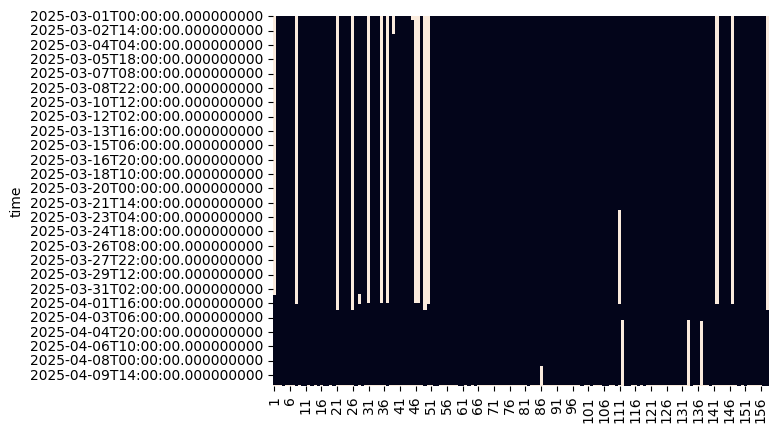

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.heatmap(merged.isna(), cbar=False)

<Axes: xlabel='time'>

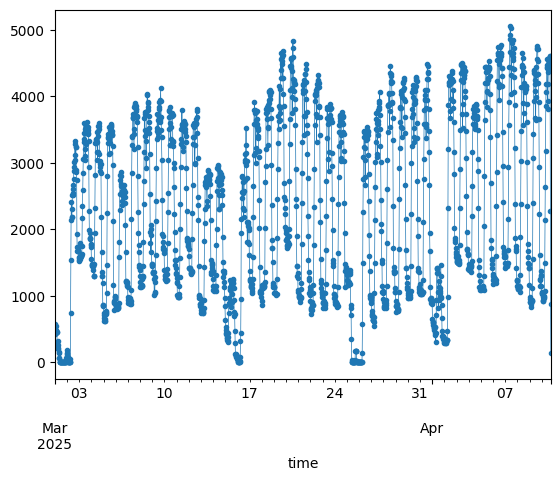

In [9]:
df_total = merged.sum(axis=1)          # df is the wide table you built
df_total.plot(marker='.', lw=0.5)
